# Autoencded Pre-Processed Data

Our Lematarized pre-processed data has 80967 features. This is because each lemmatarized word that appears in one or more of our articles is allocated a dimesion in our features' vector space.
The aim of using an autoencoder is to reduce the dimensionality of our data. This is useful as some methods we have used to verify articles do not respond well to high demnsional data (this is formally known as the 'curse of dimensionality') as our data is.

First we lemmatarize the data as we have done previously:

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv('news.csv')
df = df.drop(df.columns[0],axis=1)
df['news'] = df['title'] + ' ' + df['text']
convert_to_binary = {'REAL':1,'FAKE':0}
df['label'] = df['label'].map(convert_to_binary)
df = df.drop([df.columns[0],df.columns[1]],axis=1)
df = df.reindex(columns=['news','label'])

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re

# Creating a list of stopwords (common words which are not important to the overall meaning of the article).
stop_words = stopwords.words('english')
stop_words.extend(['the','it','in'])

# Lemmatization is the process of reducing words to their basic form, e.g. dogs->dog, running->run.
WNL = WordNetLemmatizer()

# We now iterate through each article in the dataset.
for index, row in df.iterrows():
    filtered_article = ''
    article = row['news']
    # Removing all punctuation using RegEx.
    article = re.sub(r'[^\w\s]', '', article)
    # Tokenization: changing the article from one continuous string to a list of tokens (words).
    words = [word.lower() for word in nltk.word_tokenize(article)]
    # Removing stopwords.
    words = [word for word in words if not word in stop_words]
    # Lemmatization and concatenating the words back into a single string.
    words_lemmatized = []
    for word in words:
        if word == 'us':
            words_lemmatized.append(word)
        else:
            words_lemmatized.append(WNL.lemmatize(word))
    filtered_article = " ".join([word for word in words_lemmatized])
    
    # Replace the article with the new filtered version.
    df.loc[index, 'news'] = filtered_article
    
df_input = df['news']
df_output = df['label']

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tf_idf_matrix = vectorizer.fit_transform(df_input)

x = tf_idf_matrix.toarray()
labels = df_output.values

## Autoencoder:

Now we build an autoencoder that can reduce the dimensionality of our data.

In [2]:
# installing and importanting neccessary modules (mainly Keras)

!pip install keras
!pip install tensorflow
import numpy as np
import matplotlib.pyplot as plt

from keras import Model

In [3]:
# setting random seed (for consistent results & choosing operating system)

from numpy.random import seed
from tensorflow.random import set_seed
seed(0)
set_seed(0)
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
# 'hot encoding' the data (go from binary 0 or 1 to [1,0] and [0,1] respectively)

from keras.utils import to_categorical
print("example point's binary outcome:", labels[100])
labels = to_categorical(labels)
print("same example point's one hot encoded vector:", labels[100])

example point's binary outcome: 1
same example point's one hot encoded vector: [0. 1.]


In [5]:
# splitting the data into a training data set (60%), a validation data set (20%) and a test data set (20%) 

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [6]:
# scaling the training and validation data features. Removes mean and makes the datas variance = 1. 
# learns the correct transformation on the training data and then applies to the test data.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [7]:
# importing things we need to build a neural network
from keras.models import Sequential # going to use a sequential neural network
from keras.layers import Dense # type of layer
from keras.optimizers import SGD # optimisation technique (stochastic gradient descent) used to update the weights

In [8]:
# Shape of all our data (6335 articles & 80967 features), the number of features (80967) and the number of classes (2)

print(x.shape) 
num_features = x.shape[1]
num_classes = len(np.unique(labels))
print(num_features)
print(num_classes)

(6335, 80967)
80967
2


In [19]:
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

Now we construct our first artificial neural network. The idea is to compress our data to lower dimensions and then decompress it to the same number of dimensions as our inputted data. We then measure how similar the neural networks inputted and outputted data are with a loss function (in this case we will use the mean-square error). If the loss is acceptably sufficient, we can conclude that the compressed lower dimensional data is a fair representative of our original higher dimensional data and can therefore use it in our models.

In [20]:
x_train

array([[-0.04107738,  0.        , -0.01622214, ...,  0.        ,
         0.        ,  0.        ],
       [-0.04107738,  0.        , -0.01622214, ...,  0.        ,
         0.        ,  0.        ],
       [-0.04107738,  0.        , -0.01622214, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.04107738,  0.        , -0.01622214, ...,  0.        ,
         0.        ,  0.        ],
       [-0.04107738,  0.        , -0.01622214, ...,  0.        ,
         0.        ,  0.        ],
       [-0.04107738,  0.        , -0.01622214, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
for in range 

In [9]:
model = Sequential() # its a sequential NN

model.add(Dense(32, input_dim=num_features, activation='relu')) # relu is a type of activation function
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu',name='encoded')) # this is the middle hidden layer with only 8 neurons. 
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_features))

model.compile(loss='mse', optimizer=SGD(learning_rate=0.01), metrics=['mse'])

history = model.fit(x_train, x_train, epochs=1000) # 'epochs' is the number of times we run through the training data set

Epoch 1/10
119/119 [==============================] - 8s 55ms/step - loss: 0.7655 - mse: 0.7655
Epoch 2/10
119/119 [==============================] - 3s 26ms/step - loss: 0.7551 - mse: 0.7551
Epoch 3/10
119/119 [==============================] - 3s 27ms/step - loss: 0.7413 - mse: 0.7413
Epoch 4/10
119/119 [==============================] - 4s 30ms/step - loss: 0.7519 - mse: 0.7519
Epoch 5/10
119/119 [==============================] - 3s 28ms/step - loss: 0.7534 - mse: 0.7534
Epoch 6/10
119/119 [==============================] - 3s 26ms/step - loss: 0.7755 - mse: 0.7755
Epoch 7/10
119/119 [==============================] - 3s 26ms/step - loss: 0.7722 - mse: 0.7722
Epoch 8/10
119/119 [==============================] - 3s 27ms/step - loss: 0.7706 - mse: 0.7706
Epoch 9/10
119/119 [==============================] - 3s 26ms/step - loss: 0.7544 - mse: 0.7544
Epoch 10/10
119/119 [==============================] - 3s 25ms/step - loss: 0.7733 - mse: 0.7733


In [10]:
# Now we are happy with the reliability of our neural network, here is the encoder that reduces the data to -
# just 8 dimensions

encoder_output = model.get_layer('encoded').output
encoder = Model(model.input, encoder_output)

Text(0, 0.5, 'loss')

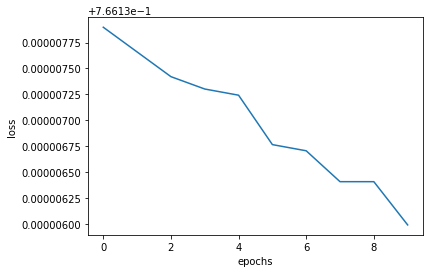

In [11]:
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

Text(0, 0.5, 'mse')

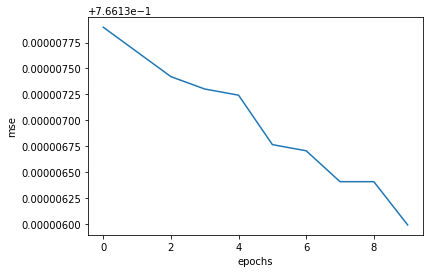

In [12]:
plt.plot(history.history['mse'])
plt.xlabel('epochs')
plt.ylabel('mse')

K Nearest Neighbours (KNN)

In [13]:
# separate the labels from the data frame
label_column = df.loc[:,'label']
labels = label_column.values
print(labels)
df_output.values

[0 0 1 ... 0 1 1]


array([0, 0, 1, ..., 0, 1, 1])

In [14]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets and test it on test data
model.fit(x_train, y_train)
model.score(x_test, y_test)*100

49.56590370955012

In [16]:
model = KNeighborsClassifier(n_neighbors=3)

model.fit(encoder(x_train),y_train)
model.score(x_test, y_test)*100

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')